In [3]:


import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import silhouette_score
import time


def get_silhouette_score(labels, all_dists):
    '''
    A Pytorch implementation of the Silhouette score.
    Accelerating the calculation by parallelizing using linear algebra.

    Modified from https://github.com/KevinMusgrave/pytorch-adapt/blob/1366df7c02
    0e3fbc4a44f4f35c13cfcc76334868/src/pytorch_adapt/layers/silhouette_score.py#L4

    Space Complexity Analysis:
        Notations: N is the number of samples.
        
        all_dists: O(N^2)
        cluster_mask: O(N^2)

    '''
    unique_labels = torch.unique(labels)
    num_samples = len(labels)
    if not (1 < len(unique_labels) < num_samples):
        raise ValueError("num unique labels must be > 1 and < num samples")
    # Although number of unique labels may not equal to `num_clusters`, each sample
    # always has a cluster label.
    assert all_dists.size(0) == all_dists.size(1)
    assert all_dists.size(0) == labels.size(0)

    # `cluster_mask` is crucial for Parallelization
    cluster_mask_bool = (labels.unsqueeze(1) == unique_labels)
    cluster_mask = F.normalize(1.0*cluster_mask_bool, p=1, dim=0) 

    scores = torch.zeros_like(labels).float()
    ## calculate the `b`
    sample2clu_dists = all_dists @ cluster_mask  # "num_samples" x "number of unique labels"
    sample2clu_dists_mask_self = sample2clu_dists + 1e5*cluster_mask_bool  # "num_samples" x "number of unique labels"
    sample_min_other_dists = torch.min(sample2clu_dists_mask_self, dim=1)[0]
    b = sample_min_other_dists  # `b` follows the standard definition in Silhouette Score
    ## calculate the `a` for the clusters with more than 1 elements
    sample2clu_dists_mask_other = sample2clu_dists[torch.nonzero(cluster_mask_bool, as_tuple=True)]
    num_elements = cluster_mask_bool.sum(dim=0)
    num_elements_sample_wise = (cluster_mask_bool * num_elements.unsqueeze(0)).sum(dim=1)
    mt1_mask = num_elements_sample_wise > 1  # "mt1" means more than 1
    # In line 3 below, we substract 1 from the number to exclude self distance
    sample2clu_dists_mask_other[mt1_mask] = sample2clu_dists_mask_other[mt1_mask] \
                                            * num_elements_sample_wise[mt1_mask] \
                                            / (num_elements_sample_wise[mt1_mask] - 1)
    a = sample2clu_dists_mask_other
    ## calculate the Silhouette Score
    # Set score=0 for all the samples assigned in the clusters which num_elements=0.
    # Here, do nothing because of the zero initialization of `scores`.
    scores_temp = (b - a) / (torch.maximum(a, b))
    scores[mt1_mask] = scores_temp[mt1_mask]
    silhouette = torch.mean(scores).item()

    return silhouette



N_list = [2**i for i in range(9, 15)]
time_cost_sklearn = np.zeros((len(N_list), 5))
time_cost_ours = np.zeros((len(N_list), 5))


for i in range(len(N_list)):
    for j in range(5):
        N = N_list[i]
        X = np.random.rand(N, 100).astype(np.float32)
        Y = np.random.choice(10, size=N)
        X_torch = torch.from_numpy(X).cuda()
        Y_torch = torch.from_numpy(Y).cuda()

        time_in = time.perf_counter()
        Sil = silhouette_score(X, Y)
        time_out = time.perf_counter()
        time_cost_sklearn[i][j] = (time_out - time_in)
        print(f"silhouette score form sklearn: {Sil}")

        time_in = time.perf_counter()
        all_dists = torch.cdist(X_torch, X_torch)
        Sil = get_silhouette_score(Y_torch, all_dists)
        time_out = time.perf_counter()
        time_cost_ours[i][j] = (time_out - time_in)
        print(f"silhouette score form ours: {Sil}")


silhouette score form sklearn: -0.011800592765212059
silhouette score form ours: -0.01180400513112545
silhouette score form sklearn: -0.01157720573246479
silhouette score form ours: -0.011580818332731724
silhouette score form sklearn: -0.012170776724815369
silhouette score form ours: -0.01217418909072876
silhouette score form sklearn: -0.011230453848838806
silhouette score form ours: -0.011233843863010406
silhouette score form sklearn: -0.011557785794138908
silhouette score form ours: -0.011561017483472824
silhouette score form sklearn: -0.007474210578948259
silhouette score form ours: -0.00747712841257453
silhouette score form sklearn: -0.00866268016397953
silhouette score form ours: -0.0086655979976058
silhouette score form sklearn: -0.007999402470886707
silhouette score form ours: -0.008002076297998428
silhouette score form sklearn: -0.008776115253567696
silhouette score form ours: -0.008778895251452923
silhouette score form sklearn: -0.008474580012261868
silhouette score form ours:

Text(0, 0.5, 'Time cost (s)')

<Figure size 640x480 with 0 Axes>

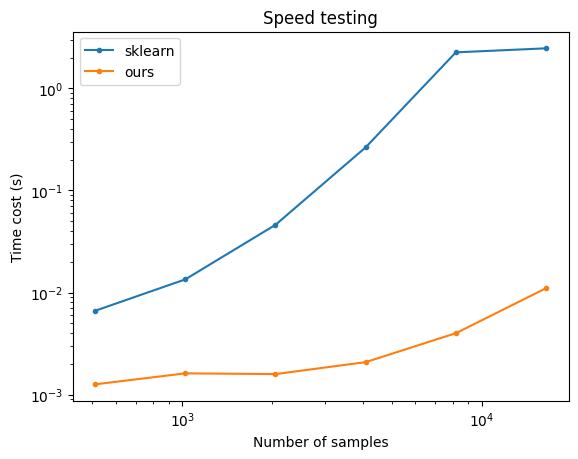

In [4]:
import matplotlib.pyplot as plt

plt.clf()
fig = plt.figure()

plt.plot(N_list, time_cost_sklearn.mean(axis=1), marker='.', label='sklearn')
plt.plot(N_list, time_cost_ours.mean(axis=1), marker='.', label='ours')
plt.xticks(N_list)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title("Speed testing")
plt.xlabel("Number of samples")
plt.ylabel("Time cost (s)")